In [1]:
# Looking at file name and extract information about the Class Label
import pandas as pd
import glob
import os
from collections import Counter
#path to the input files
filenames = glob.glob("D:\\speech_emotion_detection\\modular_code\\input\\Audio_*_Actors_01-24\\Actor_*\\*.wav")

In [2]:
filenames[1]

'D:\\speech_emotion_detection\\modular_code\\input\\Audio_Song_Actors_01-24\\Actor_01\\03-02-01-01-01-02-01.wav'

    Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):

    Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440. 
    Song file (Audio_Song_Actors_01-24.zip, 198 MB) contains 1012 files: 44 trials per actor x 23 actors = 1012.
    
    
    Each of the RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

    Filename identifiers 
        Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
        Vocal channel (01 = speech, 02 = song).
        Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
        Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
        Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
        Repetition (01 = 1st repetition, 02 = 2nd repetition).
        Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    Filename example: 02-01-06-01-02-01-12.mp4 
        Video-only (02)
        Speech (01)
        Fearful (06)
        Normal intensity (01)
        Statement "dogs" (02)
        1st Repetition (01)
        12th Actor (12)
        Female, as the actor ID number is even.

In [3]:
#To update the mlfoundry library
#pip install mlfoundry mlfoundry-ui --extra-index-url https://api.packagr.app/public --upgrade

In [4]:
import mlfoundry as mlf

# This is the default setup where the data is logged to your local and the UI server is spun on your local machine as well
#does not work
#mlf_api = mlf.set_tracking_uri() 
mlf_api = mlf.get_client() 
# Create a run- a run represents one experiment which is a unique combination of metrics, params, model files etc. 
# See this link for more details https://truefoundry-1.gitbook.io/mlfoundry/concepts
mlf_run = mlf_api.create_run(project_name='speech-emotions-project', run_name='deep-learning-model') 

In [5]:
emotions_id={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
label_counts = dict(Counter([x.split('/')[-1].split('-')[2] for x in filenames]))
label_counts = {emotions_id[k]:v for k,v in label_counts.items()}
label_counts

{'calm': 1012, 'neutral': 1440}

    Note: If we go about creating a classifier for all the 8 emotions we might have to look out for 
          class imballance for the 3 downsampled class (['neutral', 'disgust', 'surprised'])
          The way to take care of them would be:
          1. Not to look at Accuracy as a metric for validation/train
          2. We can go about Tree based algorithms (eg: XGBoost) where we can specify class weights for prediction neutrality.
          
          
          We can also drop those classes and train a classifier to only detect the balanced classes [happy, sad, fearful, angry, calm]

In [6]:
# Lets visualise how a single sound File looks like and its features
fid = filenames[200]
print(fid)

D:\speech_emotion_detection\modular_code\input\Audio_Song_Actors_01-24\Actor_05\03-02-04-02-01-01-05.wav


In [7]:
#installing required libraries
!pip install librosa==0.8.1
!pip install SoundFile==0.10.3
!pip install tensorflow==2.7.0

ERROR: Could not find a version that satisfies the requirement SoundFile==0.10.3 (from versions: 0.8.0, 0.8.1, 0.9.0, 0.9.0.post1, 0.10.1, 0.10.2, 0.10.3.post1)
ERROR: No matching distribution found for SoundFile==0.10.3


In [8]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np

In [9]:
sf = soundfile.SoundFile(fid)
data = sf.read(dtype="float32")
sample_rate = sf.samplerate

In [10]:
sf

SoundFile('D:\\speech_emotion_detection\\modular_code\\input\\Audio_Song_Actors_01-24\\Actor_05\\03-02-04-02-01-01-05.wav', mode='r', samplerate=48000, channels=1, format='WAV', subtype='PCM_16', endian='FILE')

In [11]:
data[:10]

array([1.2207031e-04, 9.1552734e-05, 9.1552734e-05, 9.1552734e-05,
       9.1552734e-05, 9.1552734e-05, 9.1552734e-05, 9.1552734e-05,
       1.2207031e-04, 9.1552734e-05], dtype=float32)

In [12]:
duration = data.shape[0]/sample_rate
duration

4.137458333333333

In [13]:
sample_rate

48000

In [14]:
import IPython.display as ipd
ipd.Audio(fid)

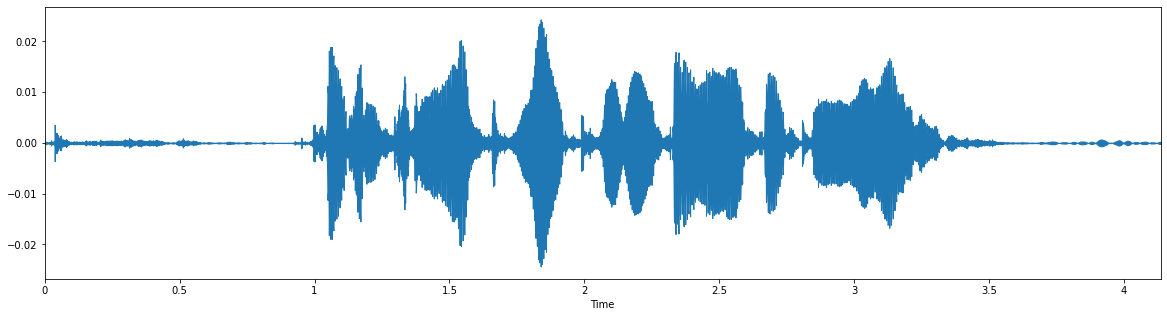

In [15]:
# Waveplot
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(20, 5))
librosa.display.waveplot(data, sr=sample_rate)

D:\speech_emotion_detection\modular_code\venv\lib\site-packages\librosa\display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


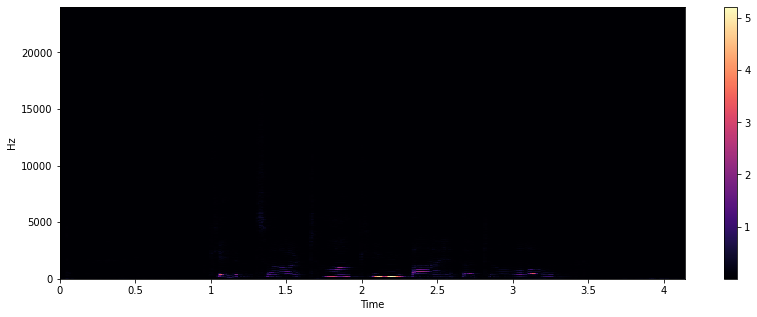

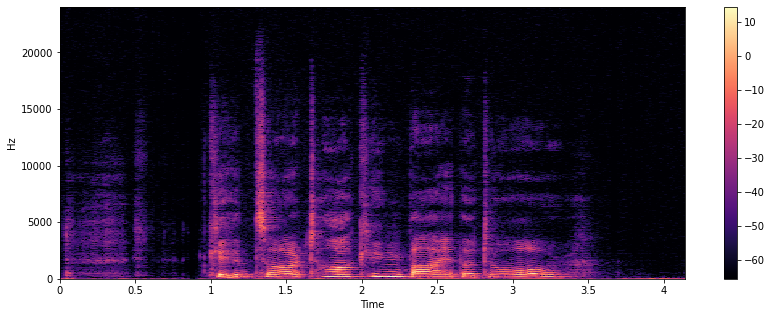

In [16]:
# Spectrogram
x_stft = librosa.stft(data)
x_db = librosa.amplitude_to_db(abs(x_stft))
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_stft, sr=sample_rate, x_axis='time', y_axis='hz', ) 
plt.colorbar()

plt.figure(figsize=(14, 5))
librosa.display.specshow(x_db, sr=sample_rate, x_axis='time', y_axis='hz', ) 
plt.colorbar()

shape: (128, 388)


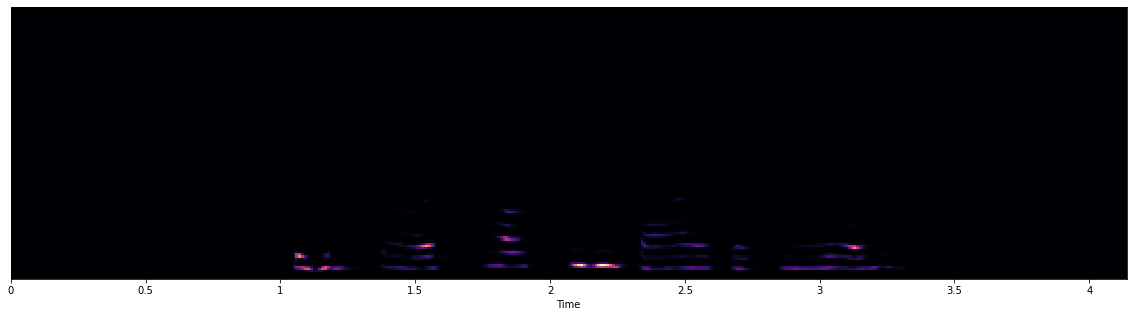

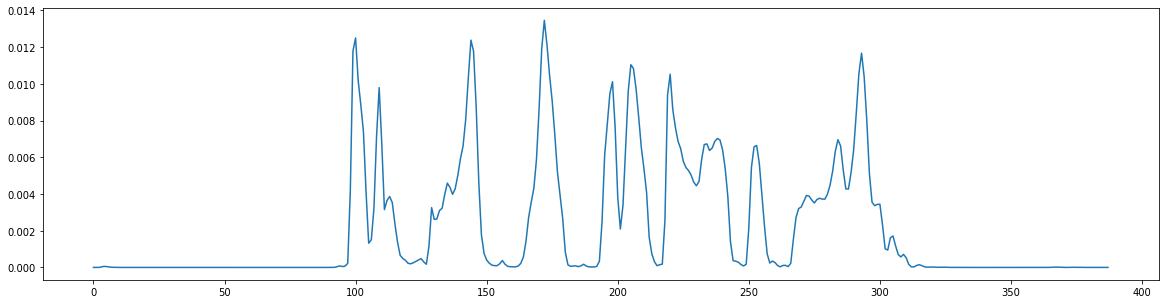

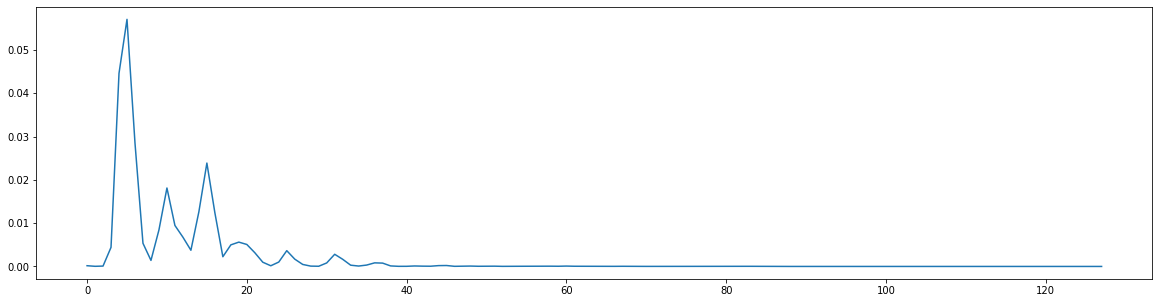

In [17]:
# mel_scpetrogram
mel_spec = librosa.feature.melspectrogram(data, sr=sample_rate )
print('shape:', mel_spec.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(mel_spec, sr=sample_rate, x_axis='time')

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=0))

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=1))

shape: (13, 388)


D:\speech_emotion_detection\modular_code\venv\lib\site-packages\librosa\display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


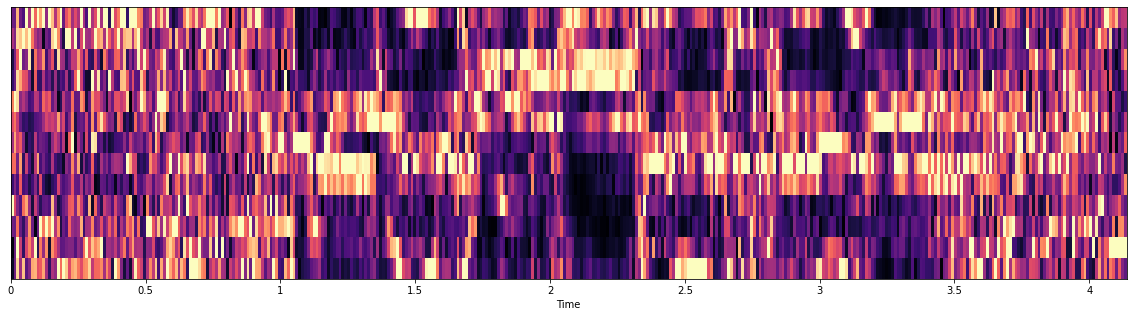

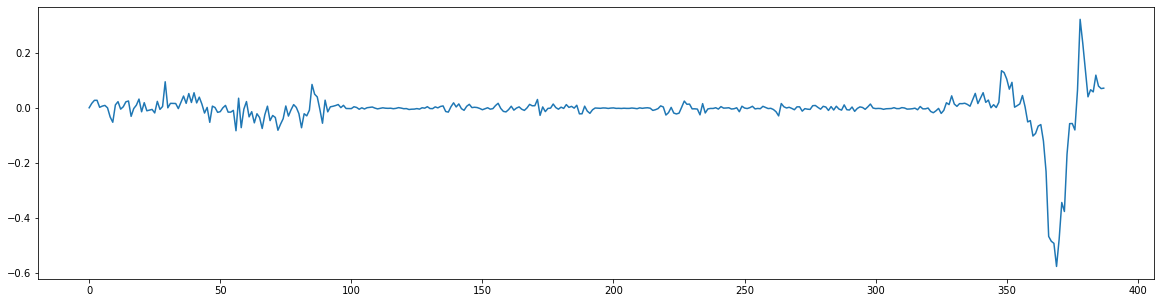

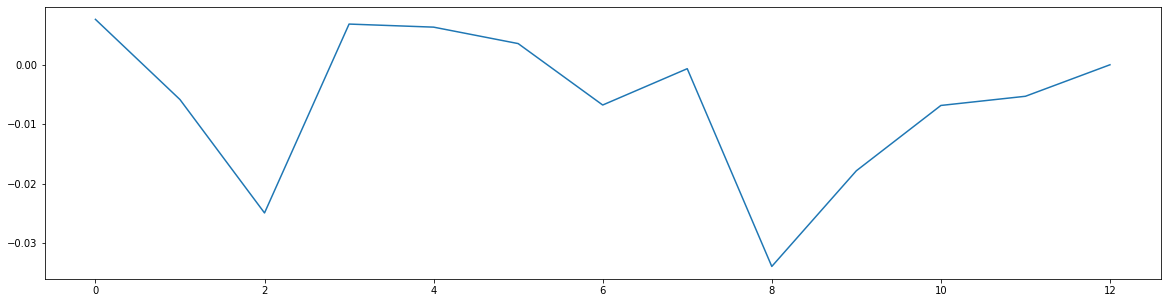

In [18]:
#chroma sftt (chroma spectogram)
x_stft = librosa.stft(data)
chroma = librosa.feature.chroma_stft(S=x_stft, sr=sample_rate, n_chroma=13)
print('shape:' ,chroma.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(chroma, sr=sample_rate, x_axis='time')


plt.figure(figsize=(20, 5))
plt.plot(np.mean(np.real(chroma), axis=0))

plt.figure(figsize=(20, 5))
plt.plot(np.mean(np.real(chroma), axis=1))

shape: (13, 388)


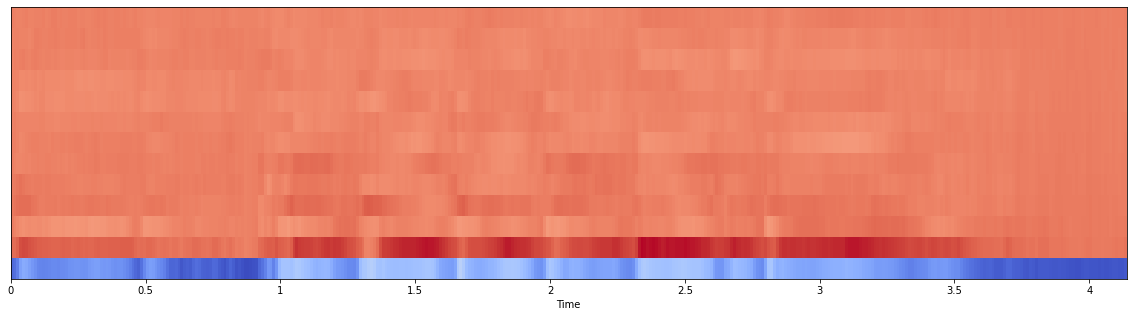

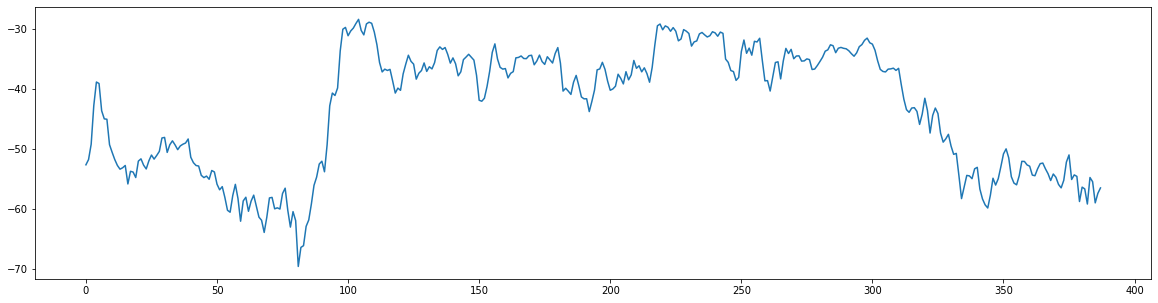

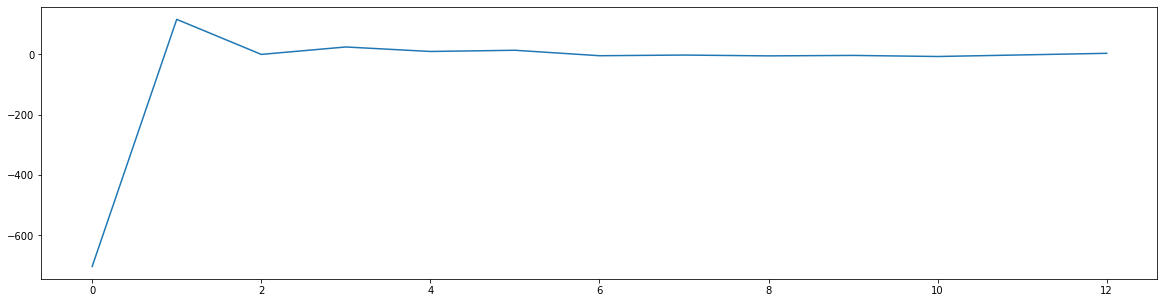

In [19]:
# MFCC: Mel-Frequency Cepstral Coefficients
mfccs = librosa.feature.mfcc(data, sr=sample_rate, n_mfcc=13)
print('shape:', mfccs.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=0))

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=1))

Number of Zero Crossing in interval:  0


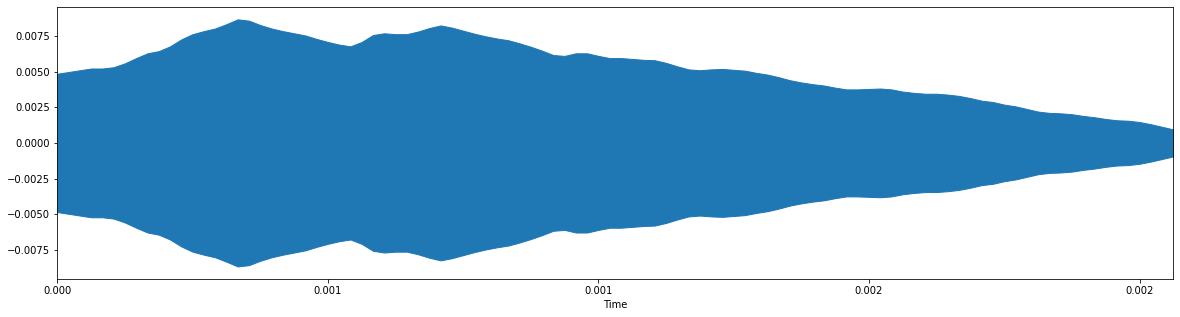

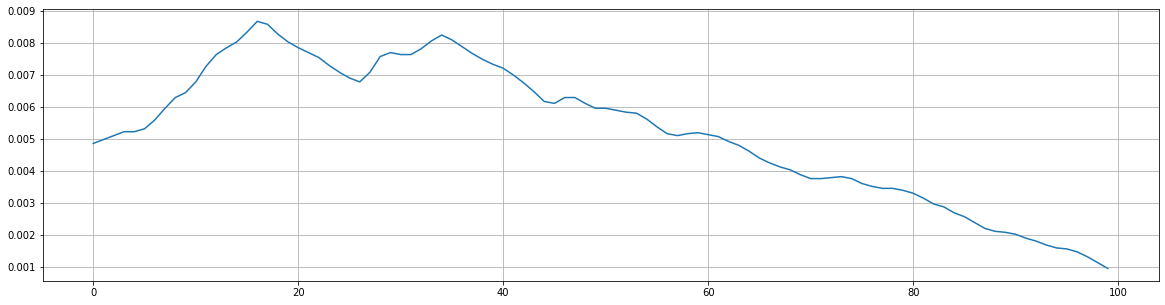

In [20]:
# Zero Crossings
plt.figure(figsize=(20, 5))
librosa.display.waveplot(data[100000:100100], sr=sample_rate)
plt.figure(figsize=(20, 5))
plt.plot(data[100000:100100])
plt.grid()
zero_crossings = librosa.zero_crossings(data[100000:100100], pad=False)
print('Number of Zero Crossing in interval: ', sum(zero_crossings))

In [21]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [22]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True, zero_crossing=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=24).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zero_crossing:
            zc = sum(librosa.zero_crossings(X, pad=False))
            result=np.hstack((result, zc))
    return result

In [23]:
from collections import Counter

In [24]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
reverse_emotions = {v:k for k,v in emotions.items()}

# observed_emotions=['calm', 'happy', 'fearful', 'disgust'] // 82
observed_emotions=list(emotions.values())


id_counts = dict(Counter([x.split('/')[-1].split('-')[2] for x in filenames]))
label_counts = {emotions[k]:v for k,v in id_counts.items()}

In [25]:
def load_data():
    x,y=[],[]
    for file in filenames:
        try:
            file_name=os.path.basename(file)
            emotion=emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                continue
            feature=extract_feature(file)
            x.append(feature)
            y.append(emotion)
        except Exception as e:
            print(e, file)
    return [np.array(x), y]

In [25]:
data_x, data_y = load_data()

Invalid shape for monophonic audio: ndim=2, shape=(229029, 2) D:\speech_emotion_detection\modular_code\input\Audio_Song_Actors_01-24\Actor_24\03-02-01-01-01-01-24.wav
Invalid shape for monophonic audio: ndim=2, shape=(172972, 2) D:\speech_emotion_detection\modular_code\input\Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-01-02-01.wav
Invalid shape for monophonic audio: ndim=2, shape=(156956, 2) D:\speech_emotion_detection\modular_code\input\Audio_Speech_Actors_01-24\Actor_01\03-01-08-01-02-02-01.wav
Invalid shape for monophonic audio: ndim=2, shape=(203403, 2) D:\speech_emotion_detection\modular_code\input\Audio_Speech_Actors_01-24\Actor_05\03-01-02-01-02-02-05.wav
Invalid shape for monophonic audio: ndim=2, shape=(166566, 2) D:\speech_emotion_detection\modular_code\input\Audio_Speech_Actors_01-24\Actor_20\03-01-03-01-02-01-20.wav
Invalid shape for monophonic audio: ndim=2, shape=(209809, 2) D:\speech_emotion_detection\modular_code\input\Audio_Speech_Actors_01-24\Actor_20\03-01-06-01-0

In [26]:
#Keras-tf model MLP with Dense

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.001)

In [27]:
reverse_emotions

{'neutral': '01',
 'calm': '02',
 'happy': '03',
 'sad': '04',
 'angry': '05',
 'fearful': '06',
 'disgust': '07',
 'surprised': '08'}

In [28]:
# Data
x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

y_train = to_categorical([int(reverse_emotions[x])-1 for x in y_train])
y_test = to_categorical([int(reverse_emotions[x])-1 for x in y_test])

# Configuration options
feature_vector_length = x_train.shape[1]
num_classes = len(observed_emotions)

input_shape = (feature_vector_length,)


In [30]:
# Create the model
np.random.seed(1) # repr


model = Sequential()
model.add(Dense(120, input_shape=input_shape, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop_cb = EarlyStopping(monitor='accuracy', patience=10)

history = model.fit(x_train, y_train, epochs=1500, batch_size=4*16, verbose=1, shuffle=True, validation_split=0.2, callbacks=[early_stop_cb], use_multiprocessing=True, workers=3, )

# Log your train accuracy and val accuracy
for acc, val_acc in zip(history.history['accuracy'], history.history['val_accuracy']):
    mlf_run.log_metrics({"accuracy":acc, "val_acc": val_acc})

# Log params of your model
param_dict = {
    "epochs" : len(history.history['accuracy']),
    "optimizer": "Adam"
}
mlf_run.log_params(param_dict)

# Test the model after training
test_results = model.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - accuracy: {test_results[1]}%')

y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

Epoch 1/1500
22/22 [==============================] - 1s 8ms/step - loss: 51.4894 - accuracy: 0.1534 - val_loss: 13.6413 - val_accuracy: 0.1545
Epoch 2/1500
22/22 [==============================] - 0s 3ms/step - loss: 10.0037 - accuracy: 0.1534 - val_loss: 6.7247 - val_accuracy: 0.1079
Epoch 3/1500
22/22 [==============================] - 0s 2ms/step - loss: 4.9268 - accuracy: 0.1899 - val_loss: 6.9156 - val_accuracy: 0.0845
Epoch 4/1500
22/22 [==============================] - 0s 3ms/step - loss: 4.3734 - accuracy: 0.1359 - val_loss: 3.5483 - val_accuracy: 0.1633
Epoch 5/1500
22/22 [==============================] - 0s 2ms/step - loss: 3.2912 - accuracy: 0.1731 - val_loss: 2.1535 - val_accuracy: 0.1487
Epoch 6/1500
22/22 [==============================] - 0s 2ms/step - loss: 3.7754 - accuracy: 0.1417 - val_loss: 2.7986 - val_accuracy: 0.1808
Epoch 7/1500
22/22 [==============================] - 0s 3ms/step - loss: 3.7425 - accuracy: 0.1388 - val_loss: 3.1998 - val_accuracy: 0.1545
Epo

D:\speech_emotion_detection\modular_code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\speech_emotion_detection\modular_code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\speech_emotion_detection\modular_code\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [31]:
# If we log our training and test dataset along with appropriate actuals and predictions, MLFoundry generates 
# meaningful metrics, data stats and feature graphs. 
X_train_df = pd.DataFrame(x_train, columns=list(range(x_train.shape[1])))
X_test_df = pd.DataFrame(x_test, columns=list(range(x_test.shape[1])))

y_train_probabilty = model.predict(x_train)
y_test_probability = model.predict(x_test)

y_hat_train = np.argmax(model.predict(x_train), axis=1)
y_hat_test = np.argmax(model.predict(x_test), axis=1)

X_train_df["targets"] = np.argmax(y_train, axis=1)
X_test_df["targets"] = np.argmax(y_test, axis=1)
X_train_df["prediction_probabilities"] = list(y_train_probabilty)
X_test_df["prediction_probabilities"] = list(y_test_probability)
X_train_df["predictions"] = y_hat_train
X_test_df["predictions"] = y_hat_test

# Log dataset stats for train dataset
mlf_run.log_dataset_stats(
    X_train_df, 
    data_slice=mlf.DataSlice.TRAIN,
    data_schema=mlf.Schema(
        feature_column_names=list(range(x_train.shape[1])),
        prediction_column_name="predictions",
        actual_column_name="targets",
        prediction_probability_column_name="prediction_probabilities"   # to calculate probability related metrics
    ),
    model_type=mlf.ModelType.MULTICLASS_CLASSIFICATION,
)

# Log dataset stats for test dataset
mlf_run.log_dataset_stats(
    X_test_df, 
    data_slice=mlf.DataSlice.TEST,
    data_schema=mlf.Schema(
        feature_column_names=list(range(x_test.shape[1])),
        prediction_column_name="predictions",
        actual_column_name="targets",
        prediction_probability_column_name="prediction_probabilities"   # to calculate probability related metrics
    ),
    model_type=mlf.ModelType.MULTICLASS_CLASSIFICATION,
)


About to log a dataframe with 330416 elements, logging might take some time to complete.


WARN: Missing config


Logged 200000 elements out of 330416


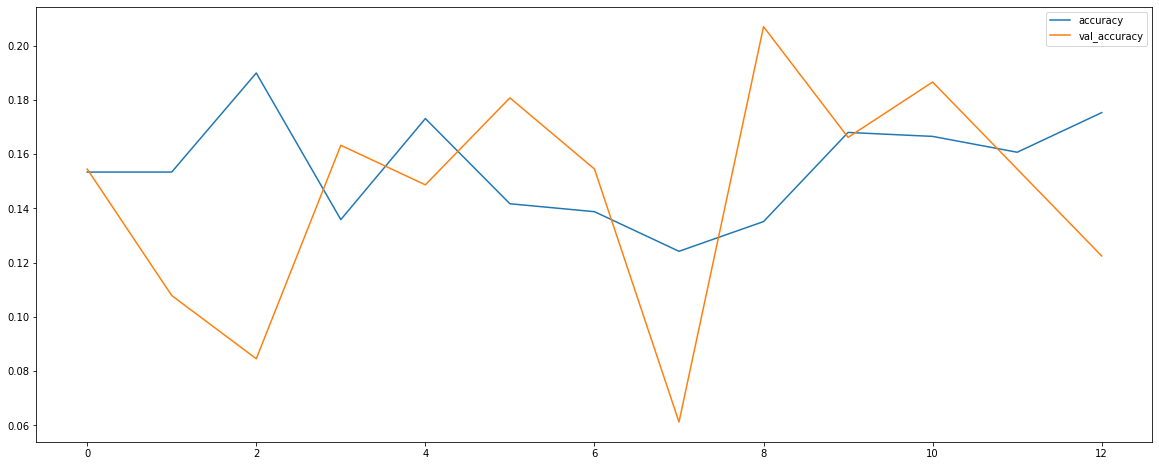

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
# plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['categorical_crossentropy'])
# plt.plot(history.history['val_categorical_crossentropy'])
plt.legend(['accuracy','val_accuracy'])
# plt.legend(['loss' ,'accuracy' ,'val_loss' ,'val_accuracy', 'categorical_crossentropy', 'val_categorical_crossentropy'])

In [33]:
# Create a new run to log this new experiment where we are grid searching across parameters
mlf_run = mlf_api.create_run(project_name='speech-emotions-project', run_name='sklearn-grid-search-experiment')

In [34]:
# Train SKlearn Model

x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

# Scikit learn model MLP
model=MLPClassifier(
    alpha=0.01, batch_size=8, epsilon=1e-08,random_state=1,
    hidden_layer_sizes=(120,100,80,50,30,20,), learning_rate='adaptive',
    max_iter=1500, verbose=0, n_iter_no_change=150
)

model.fit(x_train,y_train)

y_pred=model.predict(x_test)

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 38.56%


In [35]:
# Tuning Hyperparametrs

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model=MLPClassifier(
    batch_size='auto', epsilon=1e-08,random_state=1,learning_rate='adaptive',
    max_iter=100, verbose=0, n_iter_no_change=10
)
parameters = dict(
    alpha=[0.01, 0.001], hidden_layer_sizes=[(120,50,30,), (120,100,)]
)
clf = GridSearchCV(model, parameters)
clf.fit(x_train,y_train)


sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'param_hidden_layer_sizes',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [36]:
clf.cv_results_

{'mean_fit_time': array([0.59086518, 0.74664335, 0.59085398, 0.66074481]),
 'std_fit_time': array([0.11278607, 0.20169041, 0.12273631, 0.14666287]),
 'mean_score_time': array([0.00201125, 0.00199165, 0.00179391, 0.00238986]),
 'std_score_time': array([2.25929250e-05, 6.30011405e-04, 4.01649520e-04, 4.87102015e-04]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.001, 0.001],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(120, 50, 30), (120, 100), (120, 50, 30), (120, 100)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01, 'hidden_layer_sizes': (120, 50, 30)},
  {'alpha': 0.01, 'hidden_layer_sizes': (120, 100)},
  {'alpha': 0.001, 'hidden_layer_sizes': (120, 50, 30)},
  {'alpha': 0.001, 'hidden_layer_sizes': (120, 100)}],
 'split0_test_score': array([0.13994169, 0.1574344 , 0.27988338, 0.18658892]),
 'spl

In [37]:
# Log the best parameters from grid search
mlf_run.log_params(clf.best_params_)
clf.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (120, 50, 30)}

In [38]:
clf.best_score_

0.22893287640870885

In [39]:
# Log the best model
mlf_run.log_model(clf.best_estimator_, mlf.ModelFramework.SKLEARN)

In [40]:
# Log the best model
#mlf_run.log_model(clf.best_estimator_, mlf.ModelFramework.SKLEARN)
clf.best_estimator_

MLPClassifier(alpha=0.001, hidden_layer_sizes=(120, 50, 30),
              learning_rate='adaptive', max_iter=100, random_state=1,
              verbose=0)

In [41]:
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
label_encoder.fit(y_train)


X_train_df = pd.DataFrame(x_train, columns=list(range(x_train.shape[1])))
X_test_df = pd.DataFrame(x_test, columns=list(range(x_test.shape[1])))

y_train_probabilty = clf.predict_proba(x_train)
y_test_probability = clf.predict_proba(x_test)

y_hat_train = label_encoder.transform(clf.predict(x_train))
y_hat_test = label_encoder.transform(clf.predict(x_test))

X_train_df["targets"] = label_encoder.transform(y_train)
X_test_df["targets"] = label_encoder.transform(y_test)
X_train_df["prediction_probabilities"] = list(y_train_probabilty)
X_test_df["prediction_probabilities"] = list(y_test_probability)
X_train_df["predictions"] = y_hat_train
X_test_df["predictions"] = y_hat_test

# Log dataset stats for train dataset
mlf_run.log_dataset_stats(
    X_train_df, 
    data_slice=mlf.DataSlice.TRAIN,
    data_schema=mlf.Schema(
        feature_column_names=list(range(x_train.shape[1])),
        prediction_column_name="predictions",
        actual_column_name="targets",
        prediction_probability_column_name="prediction_probabilities"   # to calculate probability related metrics
    ),
    model_type=mlf.ModelType.MULTICLASS_CLASSIFICATION,
)

# Log dataset stats for test dataset
mlf_run.log_dataset_stats(
    X_test_df, 
    data_slice=mlf.DataSlice.TEST,
    data_schema=mlf.Schema(
        feature_column_names=list(range(x_test.shape[1])),
        prediction_column_name="predictions",
        actual_column_name="targets",
        prediction_probability_column_name="prediction_probabilities"   # to calculate probability related metrics
    ),
    model_type=mlf.ModelType.MULTICLASS_CLASSIFICATION,
)

About to log a dataframe with 330416 elements, logging might take some time to complete.
Logged 200000 elements out of 330416


In [ ]:
# Spin up the monitoring and experiment tracking UI
#!mlfoundry ui --path .
!mlfoundry ui